In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

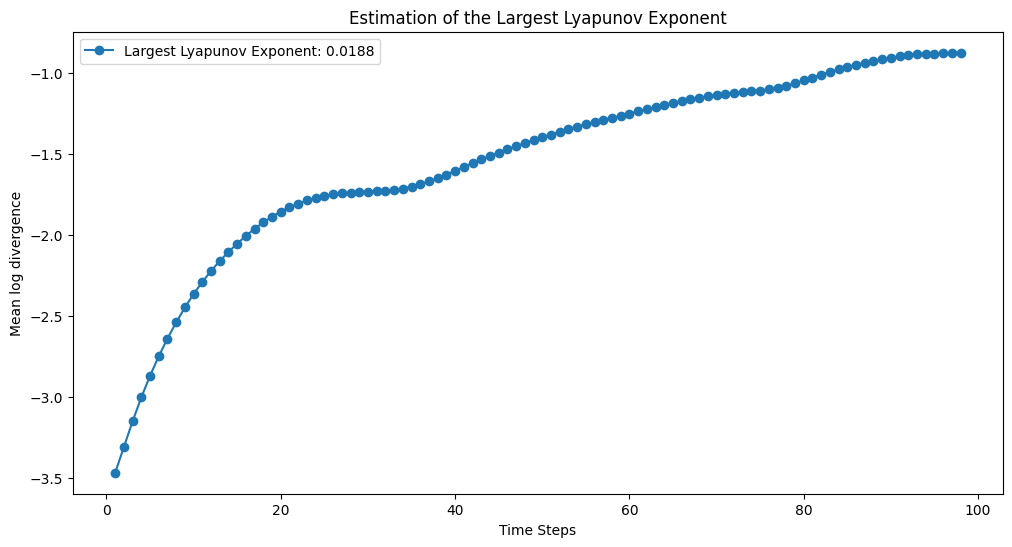

Largest Lyapunov Exponent (Lorenz): 0.0188


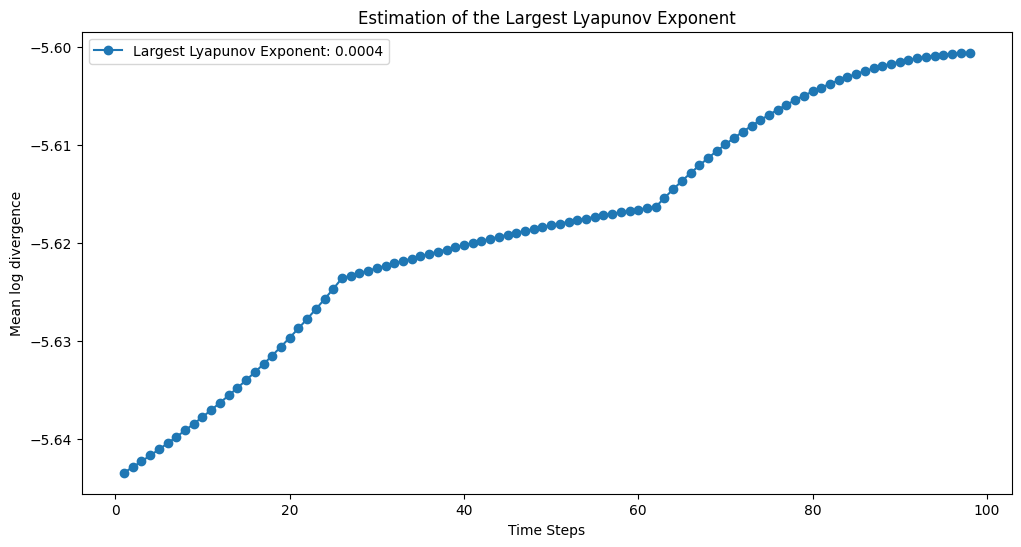

Largest Lyapunov Exponent (Sine Wave): 0.0004


In [17]:
def lorenz_system(_, state, sigma=10.0, rho=20.0, beta=1.0):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

def generate_lorenz(initial_state, t_span, dt=0.01):
    t_eval = np.arange(t_span[0], t_span[1], dt)
    solution = solve_ivp(lorenz_system, t_span, initial_state, t_eval=t_eval)
    return solution.t, solution.y.T

def time_delay_embedding(data, m, tau):
    N = len(data)
    embedded = np.empty((N - (m - 1) * tau, m))
    for i in range(m):
        embedded[:, i] = data[i * tau: N - (m - 1) * tau + i * tau]
    return embedded

def rosenstein_lyapunov(extracted_data, m=3, tau=2, max_time_steps=100):
    embedded = time_delay_embedding(extracted_data, m, tau)
    N = len(embedded)
    eps = 1e-3
    divergence = []

    initial_distances = np.inf * np.ones(N)
    neighbors_idx = np.zeros(N, dtype=int)

    for i in range(N):
        distances = cdist([embedded[i]], embedded)
        distances[0, i] = np.inf
        nearest_idx = np.argmin(distances)
        initial_distances[i] = distances[0, nearest_idx]
        neighbors_idx[i] = nearest_idx

    for i in range(1, max_time_steps):
        dist = []
        for j in range(N - i):
            index_ref = j
            index_neighbor = neighbors_idx[j]
            if index_neighbor + i >= N:
                continue
            distance_future = np.linalg.norm(embedded[index_ref + i] - embedded[index_neighbor + i])
            if distance_future > eps:
                dist.append(np.log(distance_future))

        if dist:
            divergence.append(np.mean(dist))

    linear_region = np.arange(1, min(max_time_steps, len(divergence)))
    p = np.polyfit(linear_region, divergence[1:], 1)
    l_max = p[0]

    plt.figure(figsize=(12, 6))
    plt.plot(linear_region, divergence[1:], 'o-', label=f'Largest Lyapunov Exponent: {l_max:.4f}')
    plt.xlabel('Time Steps')
    plt.ylabel('Mean log divergence')
    plt.title('Estimation of the Largest Lyapunov Exponent')
    plt.legend()
    plt.show()

    return l_max

np.random.seed(12345)
initial_state = [1.0, 1.0, 1.0]
t_span = [0, 50]

t, data = generate_lorenz(initial_state, t_span)

extracted_data = data[:, 0]

l_max = rosenstein_lyapunov(extracted_data)
print(f"Largest Lyapunov Exponent (Lorenz): {l_max:.4f}")

sampled_time = np.arange(0, 20, 0.01)
sine_wave = np.sin(sampled_time)
sine_lyapunov = rosenstein_lyapunov(sine_wave)
print(f"Largest Lyapunov Exponent (Sine Wave): {sine_lyapunov:.4f}")